In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore') 
warnings.simplefilter("ignore", ConvergenceWarning)

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('AirtrafficA4.csv')

df['PASSENGERS CARRIED'] = df['PASSENGERS CARRIED'].str.replace(',', '').astype(float)
df.fillna(1, inplace=True)


# create column for year_month
d = {'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04', 'MAY': '05', 'JUNE': '06', 'JULY': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'}
df['MONTH'] = df['MONTH'].str.replace(' ', '')
df['year_month'] = df['YEAR'].astype(str) + "-" + df['MONTH'].map(d).astype(str)
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
df['year_month_period'] = df['year_month'].dt.to_period("M")

# sort values by time, reset the indices
df.sort_values(by=['year_month'], inplace=True)
df.reset_index(inplace=True)

# create a column for logs of values
df['log_pass'] = np.log(df['PASSENGERS CARRIED'])

# df.head(50)

In [3]:
# Prepare the data and forecasting horizon
y = df.set_index('year_month_period')['PASSENGERS CARRIED']
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2023-09", periods=12, freq="ME")), is_relative=False
)

df_input = pd.DataFrame({
    'ds' : df['year_month'],
    'y' : df['PASSENGERS CARRIED']
})
# df_input

In [4]:
# Treat the outliers as 'holidays'

covid = pd.DataFrame([
    {'holiday' : '1', 'ds' : '2020-03-01', 'lower_window' : 0, 'ds_upper' : '2022-09-01'}
])

for t_col in ['ds', 'ds_upper']:
    covid[t_col] = pd.to_datetime(covid[t_col])
covid['upper_window'] = (covid['ds_upper'] - covid['ds']).dt.days

In [5]:
# Using the Prophet model
""" The `yhat` column gives the predicted values """

m = Prophet(holidays=covid)
m.fit(df_input)
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
forecast.tail(12)

22:59:19 - cmdstanpy - INFO - Chain [1] start processing
22:59:19 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,1,1_lower,1_upper,additive_terms,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
128,2023-08-31,7.505687e+06,7.137678e+06,7.551907e+06,7.505653e+06,7.505868e+06,0.0,0.0,0.0,-158729.714756,...,0.0,0.0,0.0,-158729.714756,-158729.714756,-158729.714756,0.0,0.0,0.0,7.346957e+06
129,2023-09-30,7.539613e+06,6.987410e+06,7.402823e+06,7.538040e+06,7.541329e+06,0.0,0.0,0.0,-336948.111437,...,0.0,0.0,0.0,-336948.111437,-336948.111437,-336948.111437,0.0,0.0,0.0,7.202665e+06
130,2023-10-31,7.574670e+06,7.416593e+06,7.825374e+06,7.570738e+06,7.578402e+06,0.0,0.0,0.0,34696.098607,...,0.0,0.0,0.0,34696.098607,34696.098607,34696.098607,0.0,0.0,0.0,7.609366e+06
131,2023-11-30,7.608596e+06,7.748814e+06,8.156013e+06,7.601558e+06,7.614998e+06,0.0,0.0,0.0,343408.746340,...,0.0,0.0,0.0,343408.746340,343408.746340,343408.746340,0.0,0.0,0.0,7.952005e+06
132,2023-12-31,7.643654e+06,7.369715e+06,7.789864e+06,7.632712e+06,7.652946e+06,0.0,0.0,0.0,-80214.275342,...,0.0,0.0,0.0,-80214.275342,-80214.275342,-80214.275342,0.0,0.0,0.0,7.563439e+06
133,2024-01-31,7.678711e+06,7.238592e+06,7.663038e+06,7.663583e+06,7.692071e+06,0.0,0.0,0.0,-209694.698757,...,0.0,0.0,0.0,-209694.698757,-209694.698757,-209694.698757,0.0,0.0,0.0,7.469016e+06
134,2024-02-29,7.711506e+06,7.476336e+06,7.880864e+06,7.691368e+06,7.729833e+06,0.0,0.0,0.0,-32014.943482,...,0.0,0.0,0.0,-32014.943482,-32014.943482,-32014.943482,0.0,0.0,0.0,7.679491e+06
135,2024-03-31,7.746564e+06,7.495455e+06,7.917783e+06,7.720972e+06,7.768729e+06,0.0,0.0,0.0,-47802.258490,...,0.0,0.0,0.0,-47802.258490,-47802.258490,-47802.258490,0.0,0.0,0.0,7.698761e+06
136,2024-04-30,7.780490e+06,7.952116e+06,8.385600e+06,7.750249e+06,7.808304e+06,0.0,0.0,0.0,390354.508664,...,0.0,0.0,0.0,390354.508664,390354.508664,390354.508664,0.0,0.0,0.0,8.170844e+06
137,2024-05-31,7.815547e+06,7.772546e+06,8.196011e+06,7.779443e+06,7.850314e+06,0.0,0.0,0.0,176474.790141,...,0.0,0.0,0.0,176474.790141,176474.790141,176474.790141,0.0,0.0,0.0,7.992022e+06


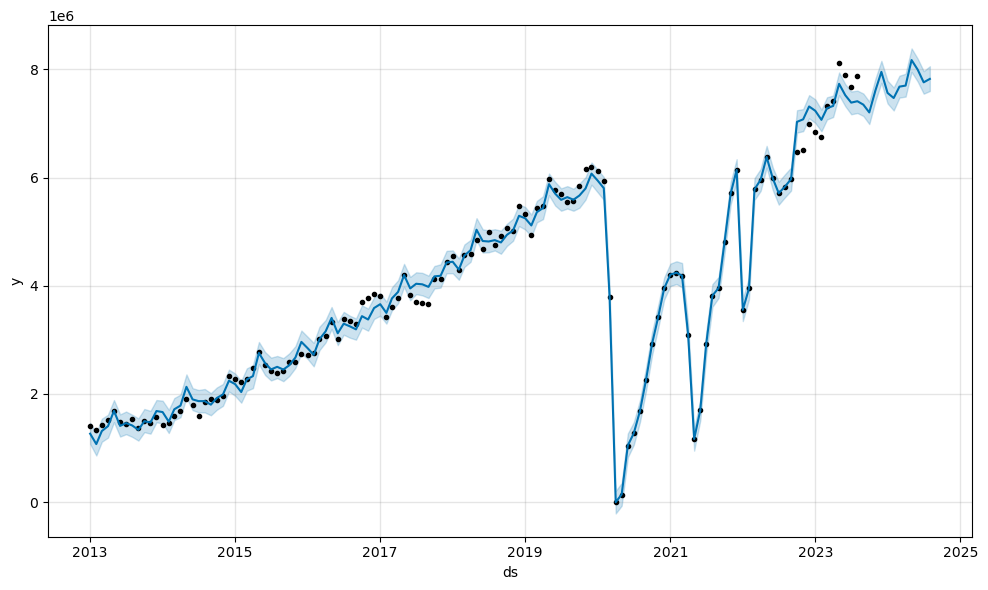

In [6]:
plot = m.plot(forecast)
plot.savefig('Prophet.png')
plot.show()